#### Cell 1
run in colab

In [4]:
!unzip /content/DATA.zip -d /content

Archive:  /content/DATA.zip
   creating: /content/DATA/
   creating: /content/DATA/TEST/
   creating: /content/DATA/TEST/ANNOTATION/
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0001.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0002.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0003.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0004.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0005.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0006.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0007.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0008.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0009.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0010.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0011.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0012.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0013.txt  
  inflating: /content/

#### Cell 2

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, hd_dir, lr_size, hr_size, hd_size, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.hd_dir = hd_dir
        self.lr_size = lr_size
        self.hr_size = hr_size
        self.hd_size = hd_size
        self.transform = transform

        self.lr_images = sorted([os.path.join(self.lr_dir, img) for img in os.listdir(self.lr_dir) if img.endswith('.pgm')])
        self.hr_images = sorted([os.path.join(self.hr_dir, img) for img in os.listdir(self.hr_dir) if img.endswith('.pgm')])
        self.hd_images = sorted([os.path.join(self.hd_dir, img) for img in os.listdir(self.hd_dir) if img.endswith('.pgm')])

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = self.lr_images[idx]
        hr_image_path = self.hr_images[idx]
        hd_image_path = self.hd_images[idx]

        # Debugging: print the file paths being accessed
        '''print(f"Loading LR image from: {lr_image_path}")
        print(f"Loading HR image from: {hr_image_path}")
        print(f"Loading HD image from: {hd_image_path}")'''

        lr_image = Image.open(lr_image_path)
        hr_image = Image.open(hr_image_path)
        hd_image = Image.open(hd_image_path)

        # Apply resizing transforms
        lr_image = transforms.Resize(self.lr_size)(lr_image)
        hr_image = transforms.Resize(self.hr_size)(hr_image)
        hd_image = transforms.Resize(self.hd_size)(hd_image)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
            hd_image = self.transform(hd_image)

        return {'lr': lr_image, 'hr': hr_image, 'hd': hd_image}

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Paths to the data directories

train_lr_dir = './DATA/TRAIN/LR'
train_hr_dir = './DATA/TRAIN/HR'
train_hd_dir = './DATA/TRAIN/HD'

test_lr_dir = './DATA/TEST/LR'
test_hr_dir = './DATA/TEST/HR'
test_hd_dir = './DATA/TEST/HD'
'''
train_lr_dir = '/content/DATA/TRAIN/LR'
train_hr_dir = '/content/DATA/TRAIN/HR'
train_hd_dir = '/content/DATA/TRAIN/HD'

test_lr_dir = '/content/DATA/TEST/LR'
test_hr_dir = '/content/DATA/TEST/HR'
test_hd_dir = '/content/DATA/TEST/HD'
'''

# Create the training and test datasets with specified sizes
train_dataset = SuperResolutionDataset(
    lr_dir=train_lr_dir,
    hr_dir=train_hr_dir,
    hd_dir=train_hd_dir,
    lr_size=(13, 137),
    hr_size=(26, 274),
    hd_size=(52, 548),
    transform=transform
)
test_dataset = SuperResolutionDataset(
    lr_dir=test_lr_dir,
    hr_dir=test_hr_dir,
    hd_dir=test_hd_dir,
    lr_size=(13, 137),
    hr_size=(26, 274),
    hd_size=(52, 548),
    transform=transform
)



# Create the dataloaders with reduced num_workers
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

# Example of iterating through the dataloader
for batch in train_loader:
    lr_images = batch['lr']
    hr_images = batch['hr']
    hd_images = batch['hd']
    print(f"LR batch shape: {lr_images.size()}")
    print(f"HR batch shape: {hr_images.size()}")
    print(f"HD batch shape: {hd_images.size()}")
    break
print(f'trainig batches are {len(train_loader)} and test batches are {len(test_loader)} with the original dataset (ICDAR2015 TextSR)')

LR batch shape: torch.Size([16, 1, 13, 137])
HR batch shape: torch.Size([16, 1, 26, 274])
HD batch shape: torch.Size([16, 1, 52, 548])
trainig batches are 35 and test batches are 8 with the original dataset (ICDAR2015 TextSR)


from https://github.com/WenjiaWang0312/TextZoom download sr_raw dataset(https://drive.google.com/file/d/1-5T89MPLtDhQWdtiqXFbBqE5bTKA5VEA/view)


#### Cell 3

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, lr_size, hr_size, hd_size, transform=None):
        self.root_dir = root_dir
        self.lr_size = lr_size
        self.hr_size = hr_size
        self.hd_size = hd_size
        self.transform = transform

        self.image_paths = []
        for folder in sorted(os.listdir(root_dir)):
            subfolder_path = os.path.join(root_dir, folder)
            if os.path.isdir(subfolder_path):
                for subfolder in sorted(os.listdir(subfolder_path)):
                    image_folder_path = os.path.join(subfolder_path, subfolder)
                    if os.path.isdir(image_folder_path):
                        images = sorted([os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith('.jpg')])
                        if len(images) >= 5:  # Ensure there are at least 5 images
                            self.image_paths.append((images[0], images[1], images[2]))  # 1st, 2nd, and 3rd images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        hd_image_path, hr_image_path, lr_image_path = self.image_paths[idx]

        hd_image = Image.open(hd_image_path).convert('L')  # Convert to grayscale
        hr_image = Image.open(hr_image_path).convert('L')  # Convert to grayscale
        lr_image = Image.open(lr_image_path).convert('L')  # Convert to grayscale

        # Apply resizing transforms
        hd_image = transforms.Resize(self.hd_size)(hd_image)
        hr_image = transforms.Resize(self.hr_size)(hr_image)
        lr_image = transforms.Resize(self.lr_size)(lr_image)

        if self.transform:
            hd_image = self.transform(hd_image)
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return {'hd': hd_image, 'hr': hr_image, 'lr': lr_image}

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Path to the root directory containing the subfolders
root_dir = './cropped'

# Create the new dataset with specified sizes
full_dataset = SuperResolutionDataset(
    root_dir=root_dir,
    lr_size=(13, 137),
    hr_size=(26, 274),
    hd_size=(52, 548),
    transform=transform
)

# Define the train-test split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the full dataset into training and testing datasets
new_train_dataset, new_test_dataset = random_split(full_dataset, [train_size, test_size])

# Combine the new training dataset with the existing training dataset
combined_train_dataset = ConcatDataset([train_dataset, new_train_dataset])

# Combine the new testing dataset with the existing testing dataset
combined_test_dataset = ConcatDataset([test_dataset, new_test_dataset])

# Create dataloaders for the combined datasets
combined_train_loader = DataLoader(combined_train_dataset, batch_size=16, shuffle=True, drop_last=True)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=16, shuffle=False, drop_last=True)

# Example of iterating through the combined train dataloader
for batch in combined_train_loader:
    lr_images = batch['lr']
    hr_images = batch['hr']
    hd_images = batch['hd']
    print(f"LR batch shape: {lr_images.size()}")
    print(f"HR batch shape: {hr_images.size()}")
    print(f"HD batch shape: {hd_images.size()}")
    break

# Example of iterating through the combined test dataloader
for batch in combined_test_loader:
    lr_images = batch['lr']
    hr_images = batch['hr']
    hd_images = batch['hd']
    print(f"LR batch shape: {lr_images.size()}")
    print(f"HR batch shape: {hr_images.size()}")
    print(f"HD batch shape: {hd_images.size()}")
    break


print(f'Training dataset batches increased from {len(train_loader)} to {len(combined_train_loader)} and the test dataset batches increased from {len(test_loader)} to {len(combined_test_loader)}')

LR batch shape: torch.Size([16, 1, 13, 137])
HR batch shape: torch.Size([16, 1, 26, 274])
HD batch shape: torch.Size([16, 1, 52, 548])
LR batch shape: torch.Size([16, 1, 13, 137])
HR batch shape: torch.Size([16, 1, 26, 274])
HD batch shape: torch.Size([16, 1, 52, 548])
Training dataset batches increased from 35 to 604 and the test dataset batches increased from 8 to 151


#### Cell 4

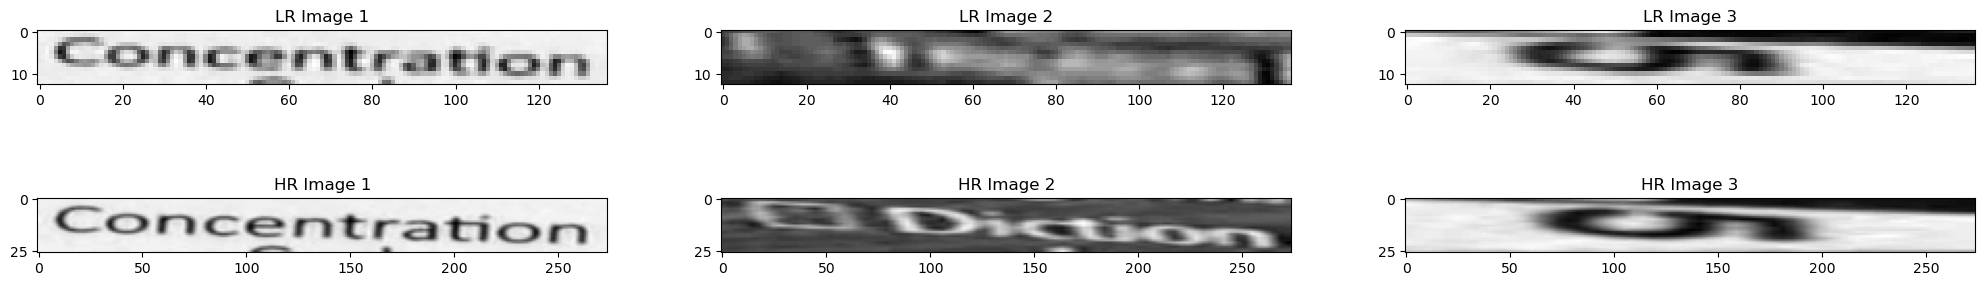

In [ ]:
import matplotlib.pyplot as plt

def visualize_inputs(test_loader,tedad):
    with torch.no_grad():
        for batch in test_loader:
            lr=batch['lr']
            #print(lr.size())
            lr = batch['lr'].cpu().numpy()  # Swap axes to (batch, height, width, channels)
            hr = batch['hr'].cpu().numpy()  # Swap axes to (batch, height, width, channels)




            fig, axes = plt.subplots(2, tedad, figsize=(25, 4))
            for i in range(tedad):
                axes[0, i].imshow(lr[i].squeeze(), cmap='gray')
                axes[0, i].set_title(f'LR Image {i+1}')
                axes[1, i].imshow(hr[i].squeeze(), cmap='gray')
                axes[1, i].set_title(f'HR Image {i+1}')

            plt.show()
            break  # Show only the first batch for visualization

visualize_inputs(combined_train_loader,3)

#### Cell 5

In [7]:
import os

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")


#### Cell 6

In [18]:
# SIREN Model Definition
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SIREN(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, hidden_layers):
        super(SIREN, self).__init__()
        self.net = [nn.Linear(in_features, hidden_features)]
        self.net += [nn.Linear(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [nn.Linear(hidden_features, out_features)]
        self.net = nn.ModuleList(self.net)

    def forward(self, x):
        for i, layer in enumerate(self.net[:-1]):
            x = torch.sin(layer(x))
        x = self.net[-1](x)
        return x

# Training and Validation Function for SIREN
def train_siren(train_loader, test_loader, model, criterion, optimizer, num_epochs=75):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            lr = batch['lr'].view(batch['lr'].size(0), -1).to(device)
            hr = batch['hr'].view(batch['hr'].size(0), -1).to(device)

            optimizer.zero_grad()
            output = model(lr)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}')

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in test_loader:
                lr = batch['lr'].view(batch['lr'].size(0), -1).to(device)
                hr = batch['hr'].view(batch['hr'].size(0), -1).to(device)

                output = model(lr)
                loss = criterion(output, hr)

                val_loss += loss.item()

            print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(test_loader)}')

# Initialize and Train SIREN
#siren_model = SIREN(in_features=13*137, out_features=26*274, hidden_features=64, hidden_layers=3).to(device)
siren_model = SIREN(in_features=13*137, out_features=26*274, hidden_features=128, hidden_layers=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(siren_model.parameters(), lr=1e-4)

#train_siren(train_loader, test_loader, siren_model, criterion, optimizer)


#### Cell 7

In [ ]:
# SIREN Training
#siren_model = SIREN(in_features=13*137, out_features=26*274, hidden_features=256, hidden_layers=5).to(device)
train_siren(combined_train_loader, combined_test_loader, siren_model, criterion, optimizer,num_epochs=20)
save_model(siren_model, "siren_model.pth")

#load_model(siren_model, "siren_model.pth")


Epoch 1, Training Loss: 0.04566325589286669
Epoch 1, Validation Loss: 0.02236206482923189
Epoch 2, Training Loss: 0.021007536784036468
Epoch 2, Validation Loss: 0.018878443333141457
Epoch 3, Training Loss: 0.01921860850416124
Epoch 3, Validation Loss: 0.018581781974247355
Epoch 4, Training Loss: 0.01913411511317981
Epoch 4, Validation Loss: 0.0186217346456864
Epoch 5, Training Loss: 0.01888540458082166
Epoch 5, Validation Loss: 0.018611620513364575
Epoch 6, Training Loss: 0.0184910990612347
Epoch 6, Validation Loss: 0.018501242123149485
Epoch 7, Training Loss: 0.018041942418176707
Epoch 7, Validation Loss: 0.017744872799229542
Epoch 8, Training Loss: 0.017662379997073124
Epoch 8, Validation Loss: 0.01718610181590382
Epoch 9, Training Loss: 0.01720899284126496
Epoch 9, Validation Loss: 0.01672862068632778
Epoch 10, Training Loss: 0.01671640614096988
Epoch 10, Validation Loss: 0.016186720623776612
Epoch 11, Training Loss: 0.01641687141447667
Epoch 11, Validation Loss: 0.01596659964678303

#### Cell 8

In [19]:
load_model(siren_model, "/content/siren_model.pth")

Model loaded from /content/siren_model.pth


#### Cell 9

In [26]:
def visualize_output(model, test_loader):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            # Ensure lr is flattened before feeding to the NeRV model
            batch_size = lr.size(0)
            lr_flat = lr.view(batch_size, -1)

            output = model(lr_flat)
            output1 = output
            output = output.view(hr.size()).cpu().numpy()  # Reshape output to match HR size

            lr_np = lr.squeeze().cpu().numpy()[0]  # Display only the first image in the batch
            hr_np = hr.squeeze().cpu().numpy()[0]
            output_np = output.squeeze()[0]

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(lr_np, cmap='gray')
            axes[0].set_title('LR Image')
            axes[1].imshow(hr_np, cmap='gray')
            axes[1].set_title('HR Image')
            axes[2].imshow(output_np, cmap='gray')
            axes[2].set_title('Output Image')

            plt.show()
            return output1  # Show only the first batch for visualization

#### Cell 10

In [ ]:
import numpy as np
import piq

def evaluate_model(model, test_loader):
    model.eval()
    psnr_values = []
    ssim_values = []
    ms_ssim_values = []

    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            # Ensure lr is flattened before feeding to the NeRV model
            batch_size = lr.size(0)
            lr_flat = lr.view(batch_size, -1)

            output = model(lr_flat)
            output = output.view(hr.size()).cpu().numpy()

            # Clamp output to the range [0, 1]
            output = np.clip(output, 0, 1)

            hr_np = hr.cpu().numpy()

            psnr_values.append(piq.psnr(torch.tensor(output), torch.tensor(hr_np)).item())
            ssim_values.append(piq.ssim(torch.tensor(output), torch.tensor(hr_np)).item())

    print(f"Average PSNR: {sum(psnr_values)/len(psnr_values)}")
    print(f"Average SSIM: {sum(ssim_values)/len(ssim_values)}")


#### Cell 11

In [ ]:
evaluate_model(siren_model, combined_test_loader)


Average PSNR: 20.403697354904075
Average SSIM: 0.42446506250378313


#### Cell 12

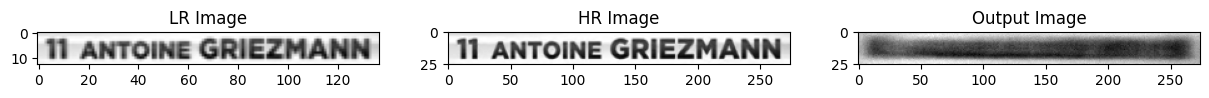

In [27]:
outt= visualize_output( siren_model, combined_test_loader)

#### Cell 13

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                            np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

class SIREN(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, hidden_layers, outermost_linear=True,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                             np.sqrt(6 / hidden_features) / hidden_omega_0)
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, is_first=False, omega_0=hidden_omega_0))
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    x.requires_grad_(True)  # Ensure x requires gradient
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

def divergence(grad, x):
    div = 0.
    for i in range(grad.shape[-1]):
        div += torch.autograd.grad(grad[..., i], x, torch.ones_like(grad[..., i]), create_graph=True)[0][..., i:i+1]
    return div

def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def create_coordinate_grid(batch_size, height, width, device):
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    grid = torch.stack([xx, yy], dim=-1)
    grid = grid.view(-1, 2).unsqueeze(0).repeat(batch_size, 1, 1)
    grid = grid.requires_grad_()  # Ensure grid requires gradient
    return grid

def train_siren(train_loader, test_loader, model, optimizer, device, num_epochs=75):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            batch_size, _, hr_height, hr_width = hr.shape
            lr_height, lr_width = lr.shape[2], lr.shape[3]

            optimizer.zero_grad()

            # Generate coordinates for high-resolution grid
            hr_coords = create_coordinate_grid(batch_size, hr_height, hr_width, device).to(device)

            # Model forward pass
            model_output = model(hr_coords)

            # Reshape model output to match hr shape
            model_output = model_output.view(batch_size, 1, hr_height, hr_width)

            loss = F.mse_loss(model_output, hr)

            # Compute laplace regularization
            laplace_loss = abs(laplace(model_output, hr_coords).mean())/1e6
            #print(laplace_loss.item())
            total_loss = loss + laplace_loss

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

        print(f'Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}')

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in test_loader:
                lr = batch['lr'].to(device)
                hr = batch['hr'].to(device)

                batch_size, _, hr_height, hr_width = hr.shape

                # Generate coordinates for high-resolution grid
                #hr_coords = create_coordinate_grid(batch_size, hr_height, hr_width, device).to(device)

                model_output = model(hr_coords)

                # Reshape model output to match hr shape
                model_output = model_output.view(batch_size, 1, hr_height, hr_width)

                loss = F.mse_loss(model_output, hr)

                # Compute laplace regularization
                #laplace_loss = laplace(model_output, hr_coords).mean()
                total_loss = loss
                #+ laplace_loss/1001

                val_loss += total_loss.item()

            print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(test_loader)}')

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the input and output sizes
input_height = 13
input_width = 137
output_height = 26
output_width = 274

in_features = 2  # Coordinate input has 2 features (x and y)
out_features = 1  # Single output for super-resolution

siren_model1 = SIREN(in_features=in_features, out_features=out_features, hidden_features=256,
                    hidden_layers=3, outermost_linear=True, first_omega_0 = 50).to(device)
optimizer = torch.optim.Adam(siren_model1.parameters(), lr=1e-5)

# Note: train_loader and test_loader need to be defined with appropriate data before training
# train_siren(train_loader, test_loader, siren_model, optimizer, device, num_epochs=500)


#### Cell 14

In [ ]:
train_siren(combined_train_loader, combined_test_loader, siren_model1, optimizer, device, num_epochs=1)

Epoch 1, Training Loss: 0.05863803895252035
Epoch 1, Validation Loss: 0.0593749906448339


#### Cell 15

In [ ]:
save_model(siren_model1,'siren_model2.pth')

Model saved to siren_model2.pth


#### Cell 16

In [9]:
load_model(siren_model1,'/content/siren_model2.pth')

Model loaded from /content/siren_model2.pth


#### Cell 17

In [15]:
tedad=4

#### Cell 18

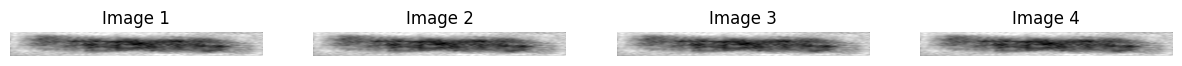

In [16]:
import torch
import matplotlib.pyplot as plt

# Function to visualize a batch of grayscale images
def visualize_batch(model_output):
    batch_size = model_output.shape[0]
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))

    for i in range(batch_size):
        # Convert tensor to numpy array and reshape it to (height, width)
        output_image = model_output[i, 0].cpu().detach().numpy()

        # Plot the image
        if batch_size == 1:
            axes.imshow(output_image, cmap='gray')
            axes.set_title(f'Image {i+1}')
            axes.axis('off')
        else:
            axes[i].imshow(output_image, cmap='gray')
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')

    plt.show()

# Assuming model_output is the output tensor from the model with shape (batch_size, 1, 26, 274)
# Example inference code to get the model_output
siren_model1.eval()
with torch.no_grad():
    for batch in combined_test_loader:
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        batch_size, _, hr_height, hr_width = hr.shape

        # Generate coordinates for high-resolution grid
        hr_coords = create_coordinate_grid(tedad, hr_height, hr_width, device).to(device)

        # Model forward pass
        model_output = siren_model1(hr_coords)

        # Reshape model output to match hr shape
        model_output = model_output.view(tedad, 1, hr_height, hr_width)

        # Visualize the output
        visualize_batch(model_output)

        # Break after first batch for demonstration
        break


#### Cell 19

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Function to evaluate the model
def evaluate_model1(model, test_loader, device):
    psnr_values = []
    ssim_values = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            # Generate coordinates for high-resolution grid
            batch_size, _, hr_height, hr_width = hr.shape
            hr_coords = create_coordinate_grid(batch_size, hr_height, hr_width, device).to(device)

            # Model forward pass
            output = model(hr_coords)

            # Reshape model output to match hr shape
            output = output.view(batch_size, 1, hr_height, hr_width)

            # Move tensors to CPU and convert to numpy arrays
            output_np = output.squeeze().cpu().numpy()
            hr_np = hr.squeeze().cpu().numpy()

            # Normalize the images between 0 and 1
            output_np = (output_np - output_np.min(axis=(1, 2), keepdims=True)) / (output_np.max(axis=(1, 2), keepdims=True) - output_np.min(axis=(1, 2), keepdims=True))
            hr_np = (hr_np - hr_np.min(axis=(1, 2), keepdims=True)) / (hr_np.max(axis=(1, 2), keepdims=True) - hr_np.min(axis=(1, 2), keepdims=True))

            for i in range(output_np.shape[0]):
                psnr_values.append(psnr(hr_np[i], output_np[i]))
                ssim_values.append(ssim(hr_np[i], output_np[i], data_range=1.0))

    print(f'Average PSNR: {np.mean(psnr_values):.4f}, Average SSIM: {np.mean(ssim_values):.4f}')
    return psnr_values, ssim_values


#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming your model is already trained and you have a test_loader
psnr_values, ssim_values = evaluate_model1(siren_model1, combined_test_loader, device)


Average PSNR: 9.2745, Average SSIM: 0.0913


# OCR

#### Cell 20

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install torchvision

#### Cell 21

for siren2 outputs

In [25]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]  # Move to CPU before converting to NumPy


    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(model_output)
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: 0 0
Image 2: 0 0
Image 3: 0 0
Image 4: 0 0


#### Cell 22

for siren1 outputs

In [29]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]  # Move to CPU before converting to NumPy


    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(outt)
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: 0 0000 000 000 000 000


# Comparison between OCR prediction on HD, HR and LR images

In [33]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]  # Move to CPU before converting to NumPy


    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(hd_images[0:10])
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: 1 20,010 1
Image 2: laurence.
Image 3: Workers administered at Mauritian.
Image 4: retrouvez les peines du shopping
Image 5: joisirs
Image 6: domfront
Image 7: recurs aux invite et just de fruits biologiques
Image 8: benzema
Image 9: reservez Vite sur
Image 10: saves 8


In [34]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]  # Move to CPU before converting to NumPy


    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(hr_images[0:10])
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: 1 2,20,990
Image 2: laurence.
Image 3: Workers administered at Marlantian.
Image 4: retrouvez les menes du shopping
Image 5: joisirs
Image 6: domfront
Image 7: return and more effective trips biologiques
Image 8: benzema
Image 9: reservez Vite sur
Image 10: savies 8


In [35]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]  # Move to CPU before converting to NumPy


    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(lr_images[0:10])
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image 1: " 2200,
Image 2: laurence.
Image 3: leveland communities in Northern Ireland.
Image 4: reformed issues in science
Image 5: joisirs
Image 6: domfront
Image 7: programming and the most successful success
Image 8: benzema
Image 9: reservez Vitesur
Image 10: a member of the South Pacific Railroad
